# Lightweight Transformer-based Model for Handwritten Character Recognition 
(https://hal.science/hal-03685976/file/A_Light_Transformer_Based_Architecture_for_Handwritten_Text_Recognition.pdf)

## ***note: Has a CNN backbone***

-----------

## Architecture  
Build up with a double Transformer architecture:  
- Image transformer as encoder: Extracts the visual features
- Text transformer as decoder: Language modeling
- Encoder: 
- Decoder: Generates word-sections sequence using visual features and previous predictions

### Encoder:  
- CNN Backbone (5 convolutions)
- Sinusodial position encoding  
- 4 layer transformer layer encoder

### Decoder: 
- Takes encoder output and along with sequence of previously predicted characters
- Additional loss in the middle of the network to help convergence

--------------


## Start pipeline

In [433]:
import os
from collections import OrderedDict

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision as tv

from PIL import Image

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

### Constants

In [434]:
DATA_PATH = f"/home/hkolstee/uniprojects/DATA/HWR/IAM-data/IAM-data/"
TRAIN_TEST_SPLIT = 0.2
BATCH_SIZE = 64
INPUT_HEIGHT = 128
# input width -> largest width in batch
# padded to get to width

### Prepare Data

In [435]:
raw_data = pd.read_fwf(DATA_PATH + "iam_lines_gt.txt", header = None)
raw_data = raw_data.values.tolist()

data = {'img_names': np.squeeze(raw_data[::2]),
        'labels': np.squeeze(raw_data[1::2])}

data = pd.DataFrame(data)
data

,img_names,labels
0,a03-017-07.png,into the pro-communist north and the
1,a03-017-05.png,"to 1958 kept the kingdom in peace, though"
2,a03-017-08.png,pro-western centre and south.
3,a03-017-02.png,in Phnom Penh indicate that he still regards
4,a03-017-06.png,at the cost of virtual partition of the country
...,...,...
7453,d06-000-08.png,fears are based upon completely
7454,d06-000-05.png,"is worrying them, to find the original"
7455,d06-000-09.png,irrational pre-conceived notions - or to
7456,d06-000-02.png,"already suggested, not to be silly or"


### TODO: Data augmentation

### Train test split

In [436]:
train, test = train_test_split(data, test_size = TRAIN_TEST_SPLIT)

# reset indices from current random state
train.reset_index(inplace = True)
test.reset_index(inplace = True)

### Create custom pytorch dataset

first, we need the input/image width we have to resize the images to.  
This is the largest image width in the entire batch of images (source paper randomly added/removed new augments each training epoch).   
For now we just take the largest width in the original images.

In [437]:
def getBiggestWidth(data: pd.DataFrame):
    biggest_width = 0

    for index in range(len(data['img_names'])):
        image_path = os.path.join(DATA_PATH, "img", data['img_names'][index])
        image = read_image(image_path)
        
        if (image.size(2) > biggest_width):
            biggest_width = image.size(2)

    return biggest_width

In [438]:
input_width = getBiggestWidth(data)
print(input_width)

2260


In [439]:
class HandWritingDataset(Dataset):
    def __init__(self, data: pd.DataFrame, img_width, img_height, batch_size):
        self.data = data
        self.batch_size = batch_size

    # function to get patches of tokens from original input image
    # def __getTokens__(self, image):
        # pass

    def __getitem__(self, index):
        # input image
        image_path = os.path.join(DATA_PATH, "img", self.data['img_names'][index])
        # torchvision read_image call
        image = read_image(image_path)
        # resize to 
        
        
        # string label
        label = self.data['labels'][index]

        return image, label

    def __len__(self):
        # return length of column
        return len(self.data)

In [440]:
train_set = HandWritingDataset(train, input_width, INPUT_HEIGHT, BATCH_SIZE)
test_set = HandWritingDataset(test, input_width, INPUT_HEIGHT, BATCH_SIZE)

### Model

Sinusodial positional encoding  
(can be changed to nn.embedding layers if we don't get good results, however that is not exactly sinusodial pos encoding like in the paper I think)

<!-- **CHANGED TO NN.EMBEDDING IN MODEL**   -->

In [441]:
class SinPosEncoding(nn.Module):
    def __init__(self, dimensionality):
        super(SinPosEncoding, self).__init__()
        self.dims = dimensionality
        self.max_len = 5000

        # position vector
        positions = torch.arange(0, self.max_len).unsqueeze(1)
        # calculate added angle for sin/cos
        angle = torch.exp(torch.arange(0, self.dims, 1) * (-np.log(10000.0) / self.dims))

        # initialize the 2D positional encodings array
        pos_encodings = torch.zeros(self.max_len, 1, self.dims)
        # calucalte encodings
        pos_encodings = torch.sin(positions * angle)

        # add to buffer for training performance (?)
        self.register_buffer('pos_encodings', pos_encodings)

    
    def forward(self, input: torch.Tensor):
        # adds the positional encoding elementwise to the tensor (seqlength, batch, embeddims)
        input += self.pos_encodings[0:input.size(1)]

        return input

For character level embedding (decoder input) we find out how many characters are present in the dataset.

In [444]:
def findNrOfCharacters(data: pd.DataFrame):
    return set(data['labels'].apply(list).sum()) 

In [449]:
unique_chars = findNrOfCharacters(data)
print("Nr of unique characters in the labels of the dataset:", len(unique_chars))
print(unique_chars)

Nr of unique characters in the labels of the dataset: 79
{')', 'D', 'i', 'g', '5', '?', 'r', '/', 'A', 'k', '-', 'a', 'W', 'N', 'm', 'E', 'C', 'n', 'M', 'H', 'U', 'V', '2', 'e', 'f', 's', '0', '!', 'p', '*', 'P', ';', ':', 'R', 'K', 'd', ',', '&', '7', 'J', ' ', '.', 'I', 'c', '#', 'Z', 'Q', '"', 'j', 'G', 'x', 'F', '(', 'z', 'w', 'l', '6', '1', 't', 'b', 'h', 'X', 'B', '9', 'L', 'v', 'Y', 'T', '3', 'u', '4', '+', 'o', 'S', 'y', 'q', "'", '8', 'O'}


Model

In [ ]:
class HWRTransformer(nn.Module):
    def __init__(self, input_width, input_height, embedding_dim, batch_size):
        super(HWRTransformer, self).__init__()

        # convolutional block (5 convolutions)
        # first convolution
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = (3,3))
        width = input_width - 2
        height = input_height - 2
        self.leakyRelu = nn.LeakyReLU()     # reuse in later layers
        self.maxPool = nn.MaxPool2d((2,2))  # reuse in later layers
        width = int(np.floor(width/2))
        height = int(np.floor(height/2))
        self.layerNorm1 = nn.LayerNorm(normalized_shape = [8, height, width])
        self.dropout = nn.Dropout(0.2)      # reuse in later layers

        # second convolutional layer
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3, 3))
        width -= 2
        height -= 2
        # after maxpool
        width = int(np.floor(width/2))
        height = int(np.floor(height/2))
        self.layerNorm2 = nn.LayerNorm(normalized_shape = [16, height, width])


        # third convolutional layer
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3, 3))
        width -= 2
        height -= 2
        # after maxpool
        width = int(np.floor(width/2))
        height = int(np.floor(height/2))
        self.layerNorm3 = nn.LayerNorm(normalized_shape = [32, height, width])

        # forth convolutional layer
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3, 3))
        width -= 2
        height -= 2
        # no maxpool
        self.layerNorm4 = nn.LayerNorm(normalized_shape = [64, height, width])

        # fifth convolutional layer (kernel size to better match shape of character)
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (4, 2))
        width -= 1
        height -= 3
        # no maxpool
        self.layerNorm5 = nn.LayerNorm(normalized_shape = [128, height, width])

        # following is convolution with width 1 which is used to flatten the current output
        self.flattenConv = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (height, 1))
        self.layerNorm6 = nn.LayerNorm(normalized_shape = [128, 1, width])

        # dense layer to upscale from 128 to 256
        self.dense1 = nn.Linear(in_features = 128, out_features = 256)
        # sinusoidal positional encoding is added to the output of the dense layer
        self.pos_encoding = SinPosEncoding(dimensionality = 256)

        # transformer encoder layers (4 stacked transformer encoder layers (4 headed attention))
        self.trans_encoder1 = nn.TransformerEncoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)
        self.trans_encoder2 = nn.TransformerEncoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)
        self.trans_encoder3 = nn.TransformerEncoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)
        self.trans_encoder4 = nn.TransformerEncoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)

        # Here starts: decoder
        # character embedding 
        self.char_embedding = nn.Embedding()

        # transformer decoder layers (4 stacked transformer encoder layers (4 headed attention))
        self.trans_decoder1 = nn.TransformerDecoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)
        self.trans_decoder2 = nn.TransformerDecoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)
        self.trans_decoder3 = nn.TransformerDecoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)
        self.trans_decoder4 = nn.TransformerDecoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)

    def forward(self, input_img, interm_outputs):
        # through 5 convolutional layers
        # first conv
        encoder_out = self.layerNorm1(self.maxPool(self.leakyRelu(self.conv1(input_img))))
        encoder_out = self.dropout(encoder_out)
        # second conv
        encoder_out = self.layerNorm2(self.maxPool(self.leakyRelu(self.conv2(encoder_out))))
        encoder_out = self.dropout(encoder_out)
        # third conv
        encoder_out = self.layerNorm3(self.maxPool(self.leakyRelu(self.conv3(encoder_out))))
        encoder_out = self.dropout(encoder_out)
        # forth conv
        encoder_out = self.layerNorm4(self.leakyRelu(self.conv4(encoder_out)))
        # fifth conv
        encoder_out = self.layerNorm5(self.leakyRelu(self.conv5(encoder_out)))

        # flatten layer
        encoder_out = self.layerNorm6(self.leakyRelu(self.flattenConv(encoder_out)))

        # dense layer (activation function not mentioned in paper) 
        # needs reshaped tensor where dims are reversed ((1, 128, 1, x) -> (1, x, 1, 128))
        encoder_out = torch.reshape(encoder_out, (encoder_out.size(0), encoder_out.size(3), encoder_out.size(2), encoder_out.size(1)))
        encoder_out = self.dense1(encoder_out)

        # add sinusodial positional information
        # needs reshape (batch, seq_len, 1, 256) -> (seq_len, batch, 256)  
        encoder_out = torch.reshape(encoder_out, (encoder_out.size(1), encoder_out.size(0), encoder_out.size(3)))
        encoder_out = self.pos_encoding(encoder_out)

        # transformer encoder layers
        encoder_out = self.trans_encoder1(encoder_out)
        encoder_out = self.trans_encoder2(encoder_out)
        encoder_out = self.trans_encoder3(encoder_out)
        encoder_out = self.trans_encoder4(encoder_out)

        # encoder output for CTC Loss
        output1 = encoder_out

        # add sinusodial positional information again
        encoder_out = self.pos_encoding(encoder_out)

        # input encoder output and predicted chars into decoder (TODO: teacher forcing)
        decoder_out = self.trans_decoder1(encoder_out, interm_outputs)
        decoder_out = self.trans_decoder2(encoder_out, interm_outputs)
        decoder_out = self.trans_decoder3(encoder_out, interm_outputs)
        decoder_out = self.trans_decoder4(encoder_out, interm_outputs)

        return output1, decoder_out

### Resize and pad images

In [ ]:
# resizes to largest width in batch x 128, keeping aspect ratio and padding image
def resizeBatch(images, image_width, image_height):
    resized_batch = torch.empty((images.size(0), 1, image_height, image_width), dtype = torch.float32)
    resize_transform = tv.transforms.Resize((image_height, image_width), antialias = True)


    for idx, image in enumerate(images):
        resized = resize_transform(image)
        resized_batch[idx] = resized

    return resized_batch

test with one image

TypeError: forward() missing 1 required positional argument: 'memory'

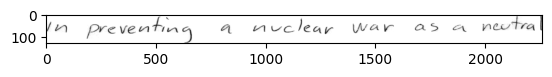

In [ ]:
hwr_transformer = HWRTransformer(input_width, INPUT_HEIGHT)

test_image, _ = train_set.__getitem__(1)
# print("Mean of image: %.2f" % test_image.float().mean().item())

# create "batch" with single image resize
test_image_batch = test_image.unsqueeze(0)
# print(test_image_batch.size())

# resize
resized_batch = resizeBatch(test_image_batch, input_width, INPUT_HEIGHT)
# print(resized_batch.size())

plt.imshow(resized_batch[0, 0, :, :], cmap = "gray")

out1, out2 = hwr_transformer(resized_batch)
print(out1.size(), out2.size())